In [1]:
from openvino.inference_engine import IECore
import matplotlib.pyplot as plt
import cv2
import numpy as np
ie = IECore()
video_path = r'data_videos\WhatsApp Video 2023-07-07 at 21.39.33.mp4'
cap = cv2.VideoCapture(video_path)

In [2]:
def head_pose_angles(image):
    head_pose_xml = r'models\head-pose-estimation-adas-0001\head-pose-estimation-adas-0001.xml'
    head_pose_bin = r'models\head-pose-estimation-adas-0001\head-pose-estimation-adas-0001.bin'
    net_head_pose = ie.read_network(model = head_pose_xml,weights = head_pose_bin)
    ext_head_pose = ie.load_network(network = net_head_pose,device_name='CPU')
    input_name = next(iter(net_head_pose.input_info))
    input_info = net_head_pose.input_info[input_name]

    head_resized = cv2.resize(image,(60,60))
    preprocessed_image = head_resized.transpose((2, 0, 1)) 
    output = ext_head_pose.infer(inputs={input_name: preprocessed_image})
    yaw = output['angle_y_fc'].flatten()[0]  # Extract the yaw angle value
    pitch = output['angle_p_fc'].flatten()[0]  # Extract the pitch angle value
    roll = output['angle_r_fc'].flatten()[0]  # Extract the roll angle valu4
    return yaw,pitch,roll


In [3]:
def Face_Detection_V(cap):
    model_xml = r'models\face-detection-adas-0001\face-detection-adas-0001.xml'
    model_bin = r'models\face-detection-adas-0001\face-detection-adas-0001.bin'
    net = ie.read_network(model=model_xml, weights=model_bin)
    exec_net = ie.load_network(network=net, device_name='CPU')
    input_name = next(iter(net.input_info))
    input_info = net.input_info[input_name]
    n, c, h, w = input_info.tensor_desc.dims



    while True:
        # Read the next frame
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize the frame to match the input size of the model
        resized_frame = cv2.resize(frame, (w, h))
        input_data = resized_frame.transpose((2, 0, 1))

        # Perform inference on the frame
        output = exec_net.infer(inputs={input_name: input_data})

        # Process the output data
        output_name = next(iter(net.outputs))
        output_data = output[output_name]
        boxes = output_data[0][0]  # Assuming a single image was processed

        # Loop through the detected faces and draw bounding boxes on the frame
        Number_Of_Faces = 0
        for box in boxes:
            confidence = box[2]
            if confidence > 0.5:  # Filter detections based on confidence threshold
                Number_Of_Faces += 1
                x_min = int(box[3] * frame.shape[1])
                y_min = int(box[4] * frame.shape[0])
                x_max = int(box[5] * frame.shape[1])
                y_max = int(box[6] * frame.shape[0])
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
  

        # Display the frame with bounding boxes
        window_width = 800  # Set the desired window width
        aspect_ratio = frame.shape[1] / frame.shape[0]
        window_height = int(window_width / aspect_ratio)
        frame = cv2.resize(frame, (window_width, window_height))
        cv2.imshow('Video', frame)

        key = cv2.waitKey(1) 
        if  key ==27 or 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    return boxes , Number_Of_Faces


In [4]:
boxes , Number_Of_Faces = Face_Detection_V(cap)

In [5]:
def show_points_v(video_path, boxes, Number_Of_Faces):
    model_xml_landmarks = r'models\facial-landmarks-35-adas-0002\facial-landmarks-35-adas-0002.xml'
    model_bin_landmarks = r'models\facial-landmarks-35-adas-0002\facial-landmarks-35-adas-0002.bin'
    net_landmarks = ie.read_network(model=model_xml_landmarks, weights=model_bin_landmarks)
    exec_net_landmarks = ie.load_network(network=net_landmarks, device_name='CPU')

    # Prepare input data for the facial landmarks detection model
    input_name_landmarks = next(iter(net_landmarks.input_info))
    input_info_landmarks = net_landmarks.input_info[input_name_landmarks]
    n_landmarks, c_landmarks, h_landmarks, w_landmarks = input_info_landmarks.tensor_desc.dims

    video = cv2.VideoCapture(video_path)
    captured_frames = []

    while True:
        ret, frame = video.read()

        if not ret:
            break

        frame_with_landmarks = frame.copy()

        for i in range(Number_Of_Faces):
            face_box = boxes[i]
            x_min = int(face_box[3] * frame.shape[1])
            y_min = int(face_box[4] * frame.shape[0])
            x_max = int(face_box[5] * frame.shape[1])
            y_max = int(face_box[6] * frame.shape[0])

            face_image = frame[y_min:y_max, x_min:x_max]            
            face_resized = cv2.resize(face_image, (w_landmarks, h_landmarks))
            input_data_landmarks = face_resized.transpose((2, 0, 1))
            output_landmarks = exec_net_landmarks.infer(inputs={input_name_landmarks: input_data_landmarks})

            # Process the output of the facial landmarks detection model
            output_name_landmarks = next(iter(net_landmarks.outputs))
            landmarks = output_landmarks[output_name_landmarks]

            # Reshape the landmarks into pairs of x and y coordinates
            landmarks_xy = landmarks.reshape(-1, 2)
               
            
            count = 0
    
            mark = []
 
            for landmark in landmarks_xy:
                

                x, y = landmark

                # Apply scaling factor to make the landmarks more visible
                x = int(x * (x_max - x_min) + x_min)
                y = int(y * (y_max - y_min) + y_min)
                if count<4:
                     mark.append(x)
                     mark.append(y)
                     count+=1

                # Draw a circle at each landmark point
            
                cv2.circle(frame_with_landmarks, (x, y), radius=2, color=(0, 0, 255), thickness=1)
      
        # Add the frame with scattered landmarks to the captured frames list
        captured_frames.append(frame_with_landmarks)
        window_width = 800  # Set the desired window width
        aspect_ratio = frame.shape[1] / frame.shape[0]
        window_height = int(window_width / aspect_ratio)
        frame_with_landmarks = cv2.resize(frame_with_landmarks, (window_width, window_height))
        cv2.imshow('Video', frame_with_landmarks)
        key = cv2.waitKey(1) 
        if  key ==27 or 0xFF == ord('q'):
            break

    # Release the video capture and close the window
    video.release()
    cv2.destroyAllWindows()
    return mark 


In [6]:
land_mark = show_points_v(video_path,boxes,Number_Of_Faces)

In [8]:
def left_eye(image, First, Second):
    # Determine the minimum and maximum x-coordinates of the eye region
    x_max, x_min = max(First[0], First[1]), min(First[0], First[1])
    
    # Determine the minimum and maximum y-coordinates of the eye region
    y_max, y_min = max(Second[0], Second[1]), min(Second[0], Second[1])
    
    # Define fixed offsets for the eye region
    x_offset = 30
    y_offset = 30
    
    # Adjust the coordinates using the fixed offsets
    x_min -= x_offset
    x_max += x_offset
    y_min -= y_offset
    y_max += y_offset
    

    
    # Extract the eye region from the image
    eye_region = image[y_min-50:y_max, x_min:x_max]
    
    return eye_region

def right_eye(image, Third, Fourth):
    # Determine the minimum and maximum x-coordinates of the eye region
    x_max, x_min = max(Third[0], Third[1]), min(Third[0], Third[1])
    
    # Determine the minimum and maximum y-coordinates of the eye region
    y_max, y_min = max(Fourth[0], Fourth[1]), min(Fourth[0], Fourth[1])
    
    # Define fixed offsets for the eye region
    x_offset = 30
    y_offset = 30
    
    # Adjust the coordinates using the fixed offsets
    x_min -= x_offset
    x_max += x_offset
    y_min -= y_offset
    y_max += y_offset
    
    
    # Extract the eye region from the image
    eye_region = image[y_min:y_max, x_min:x_max]
    
    return eye_region


from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def axes_to_array(ax):
    # Get the figure associated with the axes
    fig = ax.figure

    # Create a new canvas
    canvas = FigureCanvas(fig)

    # Render the figure on the canvas
    canvas.draw()

    # Get the RGBA buffer from the canvas
    buffer = canvas.buffer_rgba()

    # Convert the buffer to a NumPy array
    array = np.asarray(buffer)

    return array

def make_arrow(image,start_point, vector):

    end_point = (start_point[0] + vector[0], start_point[1] + vector[1])

    # Calculate the normalized vector in relation to the starting point
    diff_x = end_point[0] - start_point[0]
    diff_y = end_point[1] - start_point[1]
    magnitude = np.linalg.norm([diff_x, diff_y])
    normalized_vector = [diff_x / magnitude, diff_y / magnitude]

    # Scale down the vector to ensure visibility
    scale_factor = 10 # Adjust this factor as needed
    scaled_vector = [normalized_vector[0] * scale_factor, normalized_vector[1] * scale_factor]
  
    # Convert the image to RGB if it's in BGR format
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the image
    ax.imshow(image)
    ax.axis('off')
    ax.arrow(start_point[0], start_point[1],
             scaled_vector[0], scaled_vector[1],
             head_width=18, head_length=100,
             fc='red', ec='red')

    # Convert the buffer to a NumPy array
    array = axes_to_array(ax)
    array = cv2.cvtColor(array, cv2.COLOR_BGR2RGB)
    return array
    
def make_gaze(image,right_eye,left_eye,yaw, pitch, roll,eye_center_left,eye_center_right):
    gaze_xml = r'models\gaze-estimation-adas-0002\gaze-estimation-adas-0002.xml'
    gaze_bin = r'models\gaze-estimation-adas-0002\gaze-estimation-adas-0002.bin'
    net_gaze = ie.read_network(model=gaze_xml, weights=gaze_bin)
    ext_gaze = ie.load_network(network=net_gaze, device_name='CPU')
    input_name = next(iter(net_gaze.input_info))
    input_info = net_gaze.input_info[input_name]

    right_eye_image_resized = cv2.resize(right_eye, (60, 60))
    right_eye_input = right_eye_image_resized.transpose((2, 0, 1)) 

    # Perform gaze estimation for the left eye
    left_eye_image_resized = cv2.resize(left_eye, (60, 60))
    left_eye_input = left_eye_image_resized.transpose((2, 0, 1))  # Transpose to B, C, H, W format
    output_left = ext_gaze.infer(inputs={'right_eye_image': right_eye_input,'left_eye_image': left_eye_input, 'head_pose_angles': [yaw, pitch, roll]})
    gaze_vector = output_left['gaze_vector'].flatten()
    left_eye_center = eye_center_left
    right_eye_center = eye_center_right

    combined_center =  ((x + y) / 2 for x, y in zip(left_eye_center, right_eye_center))
    return  tuple(combined_center),gaze_vector[:2]

In [9]:
def make_gaze_arrow(cap2, land_mark):
    
    while True:
        ret, frame = cap2.read()
        if not ret:
           break
        yaw, pitch, roll = head_pose_angles(frame)
        first = land_mark[:3:2]
        second = land_mark[1:4:2]
        third = land_mark[4:7:2]
        fourth = land_mark[5::2]
        eye_center_left = (int((first[0] + first[1]) / 2), int((second[0] + second[1]) / 2))
        eye_center_right = (int((third[0] + third[1]) / 2), int((fourth[0] + fourth[1]) / 2))
        left_eye1 = left_eye(frame, first, second)
        right_eye1 = right_eye(frame, third, fourth)

        start_point  , vector = make_gaze(frame, right_eye1, left_eye1, yaw, pitch, roll, eye_center_left, eye_center_right)
        

        frame2 = make_arrow(frame,start_point,vector)


        window_width = 800  # Set the desired window width
        aspect_ratio = frame.shape[1] / frame.shape[0]
        window_height = int(window_width / aspect_ratio)

        frame2 = cv2.resize(frame2, (window_width, window_height))

        # Apply color transformation to frame2 if desired
     
      
        cv2.imshow('Video', frame2)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()



In [73]:
def Face_Direction_V(video_path):
    model_xml = r'models\face-detection-adas-0001\face-detection-adas-0001.xml'
    model_bin = r'models\face-detection-adas-0001\face-detection-adas-0001.bin'
    net = ie.read_network(model=model_xml, weights=model_bin)
    exec_net = ie.load_network(network=net, device_name='CPU')
    input_name = next(iter(net.input_info))
    input_info = net.input_info[input_name]
    n, c, h, w = input_info.tensor_desc.dims

    video = cv2.VideoCapture(video_path)
   

    while True:
        ret, frame = video.read()

        if not ret:
            break

        frame2 = frame.copy()
        
        # Resize the frame to match the input size of the model
        resized_frame = cv2.resize(frame, (w, h))
        input_data = resized_frame.transpose((2, 0, 1))

        # Perform inference on the frame
        output = exec_net.infer(inputs={input_name: input_data})

        # Process the output data
        output_name = next(iter(net.outputs))
        output_data = output[output_name]
        boxes = output_data[0][0]  # Assuming a single image was processed

        # Loop through the detected faces and draw bounding boxes on the frame
        Number_Of_Faces = 0
        for box in boxes:
            confidence = box[2]
            if confidence > 0.5:  # Filter detections based on confidence threshold
                Number_Of_Faces += 1
                x_min = int(box[3] * frame.shape[1])
                y_min = int(box[4] * frame.shape[0])
                x_max = int(box[5] * frame.shape[1])
                y_max = int(box[6] * frame.shape[0])
                cv2.rectangle(frame2, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                first = land_mark[:3:2]
                second = land_mark[1:4:2]
                third = land_mark[4:7:2]
                fourth = land_mark[5::2]
                yaw, pitch, roll = head_pose_angles(frame)
                right_eye_image,left_eye_image = right_eye(frame,third,fourth),left_eye(frame,first,second)
     
                eye_center_left = (int((first[0] + first[1]) / 2), int((second[0] + second[1]) / 2))
                eye_center_right = (int((third[0] + third[1]) / 2), int((fourth[0] + fourth[1]) / 2))
                gaze_center, gaze_vector = make_gaze(frame, right_eye_image, left_eye_image, yaw, pitch, roll, eye_center_left, eye_center_right)
           
                gaze_direction = head_pose_direction(gaze_vector)
         
                cv2.putText(frame2, gaze_direction, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Display the frame with bounding boxes
        window_width = 600  # Set the desired window width
        aspect_ratio = frame2.shape[1] / frame2.shape[0]
        window_height = int(window_width / aspect_ratio)
        frame2 = cv2.resize(frame2, (window_height*2, window_width))
        cv2.imshow('Video', frame2)

        key = cv2.waitKey(1) 
        if  key ==27 or 0xFF == ord('q'):
            break

    video.release()
    cv2.destroyAllWindows()
    return 1


In [74]:
def normalize_vector(vector):
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector
    return vector / norm

def head_pose_direction(gaze_vector):
    normalized_vector = normalize_vector(gaze_vector)

    if normalized_vector[0] > 0.5:
        if normalized_vector[1] > 0.3:
            direction = 'Up-left'
        elif normalized_vector[1] < 0.3:
            direction = 'Down-left'
        else:
            direction = 'left'
    elif normalized_vector[0] < -0.3:
        if normalized_vector[1] > 0.3:
            direction = 'Up-right'
        elif normalized_vector[1] < -0.3:
            direction = 'Down-right'
        else:
            direction = 'right'
    elif normalized_vector[1] > 0.3:
        direction = 'Up'
    elif normalized_vector[1] < -0.3:
        direction = 'Down'
    else:
        direction = 'Straight'

    return direction


In [75]:
# cap = cv2.VideoCapture(video_path)
Face_Direction_V(video_path)

1

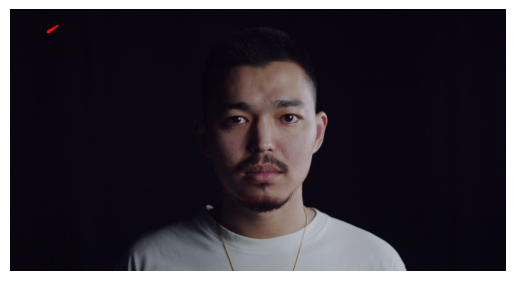

In [ ]:
# video_path = r'C:\Users\91702\OneDrive\Desktop\OpenVIno\data_videos\pexels.avi'
# cap = cv2.VideoCapture(video_path)
# a = make_gaze_arrow(cap,land_mark)

In [76]:

video = cv2.VideoCapture(r'data_videos\fast.mp4')

# Get the original video's properties
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video.get(cv2.CAP_PROP_FPS)

# Define the desired speedup factor
speedup_factor = 2  # Adjust this value to change the speed

# Define the output video file
output_file = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps * speedup_factor, (width, height))

# Read and write frames from the input video, skipping frames based on the speedup factor
frame_count = 0
while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    if frame_count % speedup_factor == 0:
        output_file.write(frame)

    frame_count += 1

# Release the resources
video.release()
output_file.release()
